so I will have data as ndarray at bottleneck as N by D
I will have the class labels acquired by kmeans
I want to find correspondance samples as
a) two random samples that are in cluster
b) some sample and the center sample

which wil be acquired as in and out indices by a function that takes nxd array and cluster labels

In [40]:
import os, sys
import importlib as impL
import numpy as np
from pandas import DataFrame as pd_df

In [41]:
def get_parent_dir(x):
    return os.path.dirname(x)
get_parent_dir(sys.path[0])

'/home/doga/GithUBuntU/keyhandshapediscovery'

In [42]:
sys.path.insert(1,os.path.join(get_parent_dir(sys.path[0]),'vae_torch'))
sys.path.insert(1,get_parent_dir(sys.path[0]))

In [43]:
import vae_torch_model as vtm
import helperFuncs as funcH
desktop_dir = funcH.getVariableByComputerName('desktop_dir')

/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [44]:
def load_from_saved_corr_file(fn = '/home/doga/Desktop/correspondance_find.npz'):
    a = np.load(fn)
    predictions = a['predictions']
    bottleneck_vec = a['bottleneck_vec']
    labels = a['labels']
    print("loaded from file - ", fn)
    print(predictions.shape)
    print(bottleneck_vec.shape)
    print(labels.shape)
    return bottleneck_vec, predictions, labels

def analyze_corresondance_results(correspondance_tuple, centroid_df, pred_vec, lab_vec):
    if centroid_df is not None:
        df = pd_df({'labels': lab_vec[np.asarray(centroid_df['sampleID'], dtype=int)],
                    'klusterID': np.asarray(centroid_df['klusterID'], dtype=int),
                    'sampleCounts': np.asarray(centroid_df['num_of_samples'], dtype=int)})
        print('correspondance results({:}):'.format(len(correspondance_tuple[0])))
        print(df.groupby(['labels'])[['labels', 'sampleCounts']].sum())
    
    corr_in_clust = pred_vec[correspondance_tuple[0]]
    corr_ou_clust = pred_vec[correspondance_tuple[1]]
    _confMat_corr_preds = confusion_matrix(corr_in_clust, corr_ou_clust)
    acc_corr_preds = 100 * np.sum(np.diag(_confMat_corr_preds)) / np.sum(
        np.sum(_confMat_corr_preds))
    print("_confMat_corr_preds - acc({:6.4f})".format(acc_corr_preds))

    corr_in_labels = lab_vec[correspondance_tuple[0]]
    corr_ou_labels = lab_vec[correspondance_tuple[1]]
    _confMat_corr = confusion_matrix(corr_in_labels, corr_ou_labels)
    acc_corr = 100 * np.sum(np.diag(_confMat_corr)) / np.sum(np.sum(_confMat_corr))
    print("confMat - acc({:6.4f}), correspondance match:\n".format(acc_corr), pd_df(_confMat_corr))

b_v = np.random.rand(10,3)
#print(b_v)

In [7]:
# np.savez('/home/doga/Desktop/correspondance_find.npz', bottleneck_vec=bottleneck_vec, predictions=pred_vec, labels=lab_vec)
bottleneck_vec, pred_vec, lab_vec = load_from_saved_corr_file(os.path.join(desktop_dir, 'correspondance_find_epoch1009_conf516.npz'))

loaded from file -  /home/doga/Desktop/correspondance_find_epoch1009_conf516.npz
(60000,)
(60000, 32)
(60000,)


In [45]:
impL.reload(funcH)
def get_cluster_correspondance_ids_jupy(X, cluster_ids, correspondance_type="shuffle", verbose=0):
    # uses X to find the center sample
    # returns inds_in, inds_out where:
    # if correspondance_type=='shuffle'
    # inds_in : shuffled indices of a cluster
    # inds_out: shuffled indices of a cluster
    # elseif correspondance_type=='centered'
    # inds_in : some_sample_id
    # inds_out: the center of cluster of that sample_id
    centroid_df = funcH.get_cluster_centroids(ft=X, predClusters=cluster_ids, verbose=0)
    uq_pr = np.unique(cluster_ids)
    inds_in = []
    inds_out = []
    num_of_samples = []
    for i in range(len(uq_pr)):
        cluster_id = uq_pr[i]
        cluster_inds = funcH.getInds(cluster_ids, i)
        num_of_samples.append(len(cluster_inds))
        if correspondance_type == 'shuffle':
            iin_cur = cluster_inds.copy()
            np.random.shuffle(iin_cur)
            out_cur = cluster_inds.copy()
            np.random.shuffle(out_cur)
        elif 'knear' in correspondance_type:
            if verbose > 0:
                print("\n***\nknear-row{:}\n".format(i), cluster_inds)
            k = int(correspondance_type.replace('knear', ''))
            # look at the closest k samples for each sample
            X_sub = X[cluster_inds, :]
            k = np.minimum(len(cluster_inds), k)
            d_inds, d_vals = funcH.get_dist_inds(X_sub, k=k, metric="euclidean", verbose=0)
            # d_inds are from 0 to len(cluster_inds)
            # we want to switcth them with real cluster_inds
            if verbose > 2:
                print("cluster_inds:\n", cluster_inds)
                print("d_inds in:", d_inds)
            # d_inds.shape = [len(cluster_inds), k]
            # each row represents a sample and all columns represent its nearest neighbours
            # so i need to have each corr and k neighbours as correspondant frames
            sidx = np.array([cluster_inds, ] * k).T.flatten()
            if verbose > 1:
                print("i = ", i)
                print("sidx = \n", sidx)
            d_inds = cluster_inds[d_inds.flatten()]
            if verbose > 1:
                print("d_inds = \n", d_inds)
            iin_cur = sidx.copy()
            out_cur = d_inds.copy()
        else:
            center_sample_inds = centroid_df['sampleID'].iloc[i]
            if verbose > 0:
                print("cluster_id({:-3d}), sampleCount({:-4d}), centerSampleId({:-5d})".format(int(cluster_id),
                                                                                               len(cluster_inds),
                                                                                               center_sample_inds))
            # inds_in <--all sampleids except cluster center
            # inds_out<--cluster sample id with length of inds_in
            iin_cur = np.asarray(cluster_inds[np.where(center_sample_inds != cluster_inds)], dtype=int).squeeze()
            out_cur = np.asarray(np.ones(iin_cur.shape) * center_sample_inds, dtype=int)

        if verbose > 0:
            print("iin_cur.shape{:}, out_cur.shape{:}".format(iin_cur.shape, out_cur.shape))
            #if i == 0:
            print("iin=", iin_cur)
            print("out=", out_cur)
        inds_in.append(iin_cur)
        inds_out.append(out_cur)

    # first concatanate the lists into ndarray
    inds_in = np.asarray(np.concatenate(inds_in), dtype=int)
    inds_out = np.asarray(np.concatenate(inds_out), dtype=int)

    if True:  # 'knear' not in correspondance_type:
        # now a-b and b-a
        ii_ret = np.asarray(np.concatenate([inds_in, inds_out]), dtype=int)
        io_ret = np.asarray(np.concatenate([inds_out, inds_in]), dtype=int)
    else:
        ii_ret = inds_in.copy()
        io_ret = inds_out.copy()

    # now shuffle so that clusters not sorted in learning
    print("shuffle all")
    p = np.random.permutation(len(ii_ret))
    ii_ret = ii_ret[p]
    io_ret = io_ret[p]

    if verbose > 0:
        print("inds_in.shape{:}, inds_out.shape{:}".format(inds_in.shape, inds_out.shape))
    centroid_df['num_of_samples'] = num_of_samples
    return (ii_ret, io_ret), centroid_df

In [46]:
correspondance_type = 'knear1'
impL.reload(funcH)
correspondance_tuple, centroid_df = get_cluster_correspondance_ids_jupy(X=bottleneck_vec, cluster_ids=pred_vec,
                                    correspondance_type=correspondance_type,
                                    verbose=0)

NameError: name 'bottleneck_vec' is not defined

In [10]:
from sklearn.metrics import confusion_matrix
analyze_corresondance_results(correspondance_tuple, centroid_df, pred_vec, lab_vec)

correspondance results(120000):
        labels  sampleCounts
labels                      
0            0          5267
1            4          4972
2            8          8264
3            9          4731
4           12          6064
5           10          5262
6           24          7302
7            7          3106
8           24          4664
9           45         10368
_confMat_corr_preds - acc(100.0000)
confMat - acc(73.1167), correspondance match:
       0      1     2     3     4     5     6     7      8      9
0  8520    107   215   863   122     8  2027     1    171      2
1   107  10930    97   602    36     0   120     0     10      0
2   215     97  6834   184  2349     3  2108     0    144      1
3   863    602   184  8734   858     2   633     0    126      2
4   122     36  2349   858  6666     0  1804     0     97      1
5     8      0     3     2     0  9942     8  1230     84    665
6  2027    120  2108   633  1804     8  5218     0    264      2
7     1      0   

In [ ]:
impL.reload(funcH)
D, sort_inds = funcH.create_dist_mat(x=bottleneck_vec, metric="euclidean", verbose=0, use_less=True)

In [ ]:
D = np.float32(D)

In [ ]:
impL.reload(funcH)
dist_dict = funcH.get_linearized_distance_matrix(D,verbose=1, sort_dist="ascend")

In [ ]:
from sklearn.metrics import confusion_matrix
analyze_corresondance_results((corr_A,corr_B), centroid_df=None, pred_vec=pred_vec, lab_vec=lab_vec)

In [ ]:
impL.reload(funcH)
corr_inds, centroid_df = funcH.get_cluster_correspondance_ids(b_v, cluster_ids=[0,0,0,0,1,1,2,2,1,1], correspondance_type="knear4", verbose=0)
print(pd_df({"in":corr_inds[0],"out":corr_inds[1]}))
print(centroid_df)

In [ ]:
a,  centroid_df = get_cluster_correspondance_ids(bottleneck_vec, predictions, correspondance_type="shuffle")

In [ ]:
import vae_scripts as vs

In [ ]:
print(corr_A.shape)
print(corr_B.shape)

In [ ]:
corr_B = np.squeeze(sort_inds[0,:])
corr_A = np.arange(corr_B.size,dtype=int)

In [ ]:
vs.run_compare_list(experiments_folder="/home/doga/DataFolder/vaesae_experiments_cor",
                     data_log_keys=['tr_te', 'te'],
                     loss_key_list=[ 'bottleneck_kmeans', 'reconstruction'],
                     exp_base_name='exp_linear_vae_FMNIST_is28_cf',
                     ae_f_name_base='ae_ft_linear_vae_FMNIST_is28.npy')

tr_te  - log is loaded with len:  24
te  - log is loaded with len:  24
skipping -  valid loss
skipping -  reconstruction
skipping -  sparsity
bottleneck_kmeans :
tr_te: min(@epoc22:65.3650), max(@epoc12:70.9967), max_list([21 10 13 11 12])
te: min(@epoc0:61.1800), max(@epoc17:72.1100), max_list([12 14 10 21 17])
skipping -  bottleneck_act
0*/home/doga/DataFolder/vaesae_experiments/FM/exp_conv_ae_simple_is28_cf454/btl_000_tr_va_.png*
0*/home/doga/DataFolder/vaesae_experiments/FM/exp_conv_ae_simple_is28_cf454/btl_000_tr_te_.png*
1*/home/doga/DataFolder/vaesae_experiments/FM/exp_conv_ae_simple_is28_cf454/btl_011_tr_va_.png*
1*/home/doga/DataFolder/vaesae_experiments/FM/exp_conv_ae_simple_is28_cf454/btl_011_tr_te_.png*
2*/home/doga/DataFolder/vaesae_experiments/FM/exp_conv_ae_simple_is28_cf454/btl_023_tr_va_.png*
2*/home/doga/DataFolder/vaesae_experiments/FM/exp_conv_ae_simple_is28_cf454/btl_023_tr_te_.png*


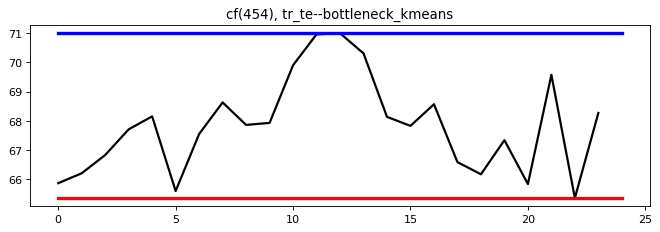

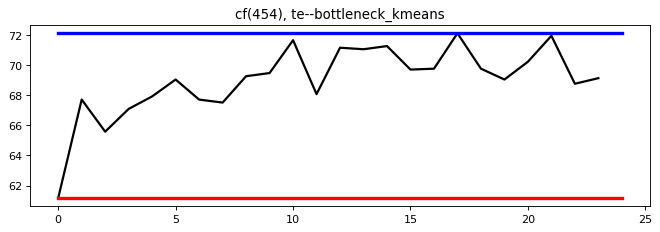

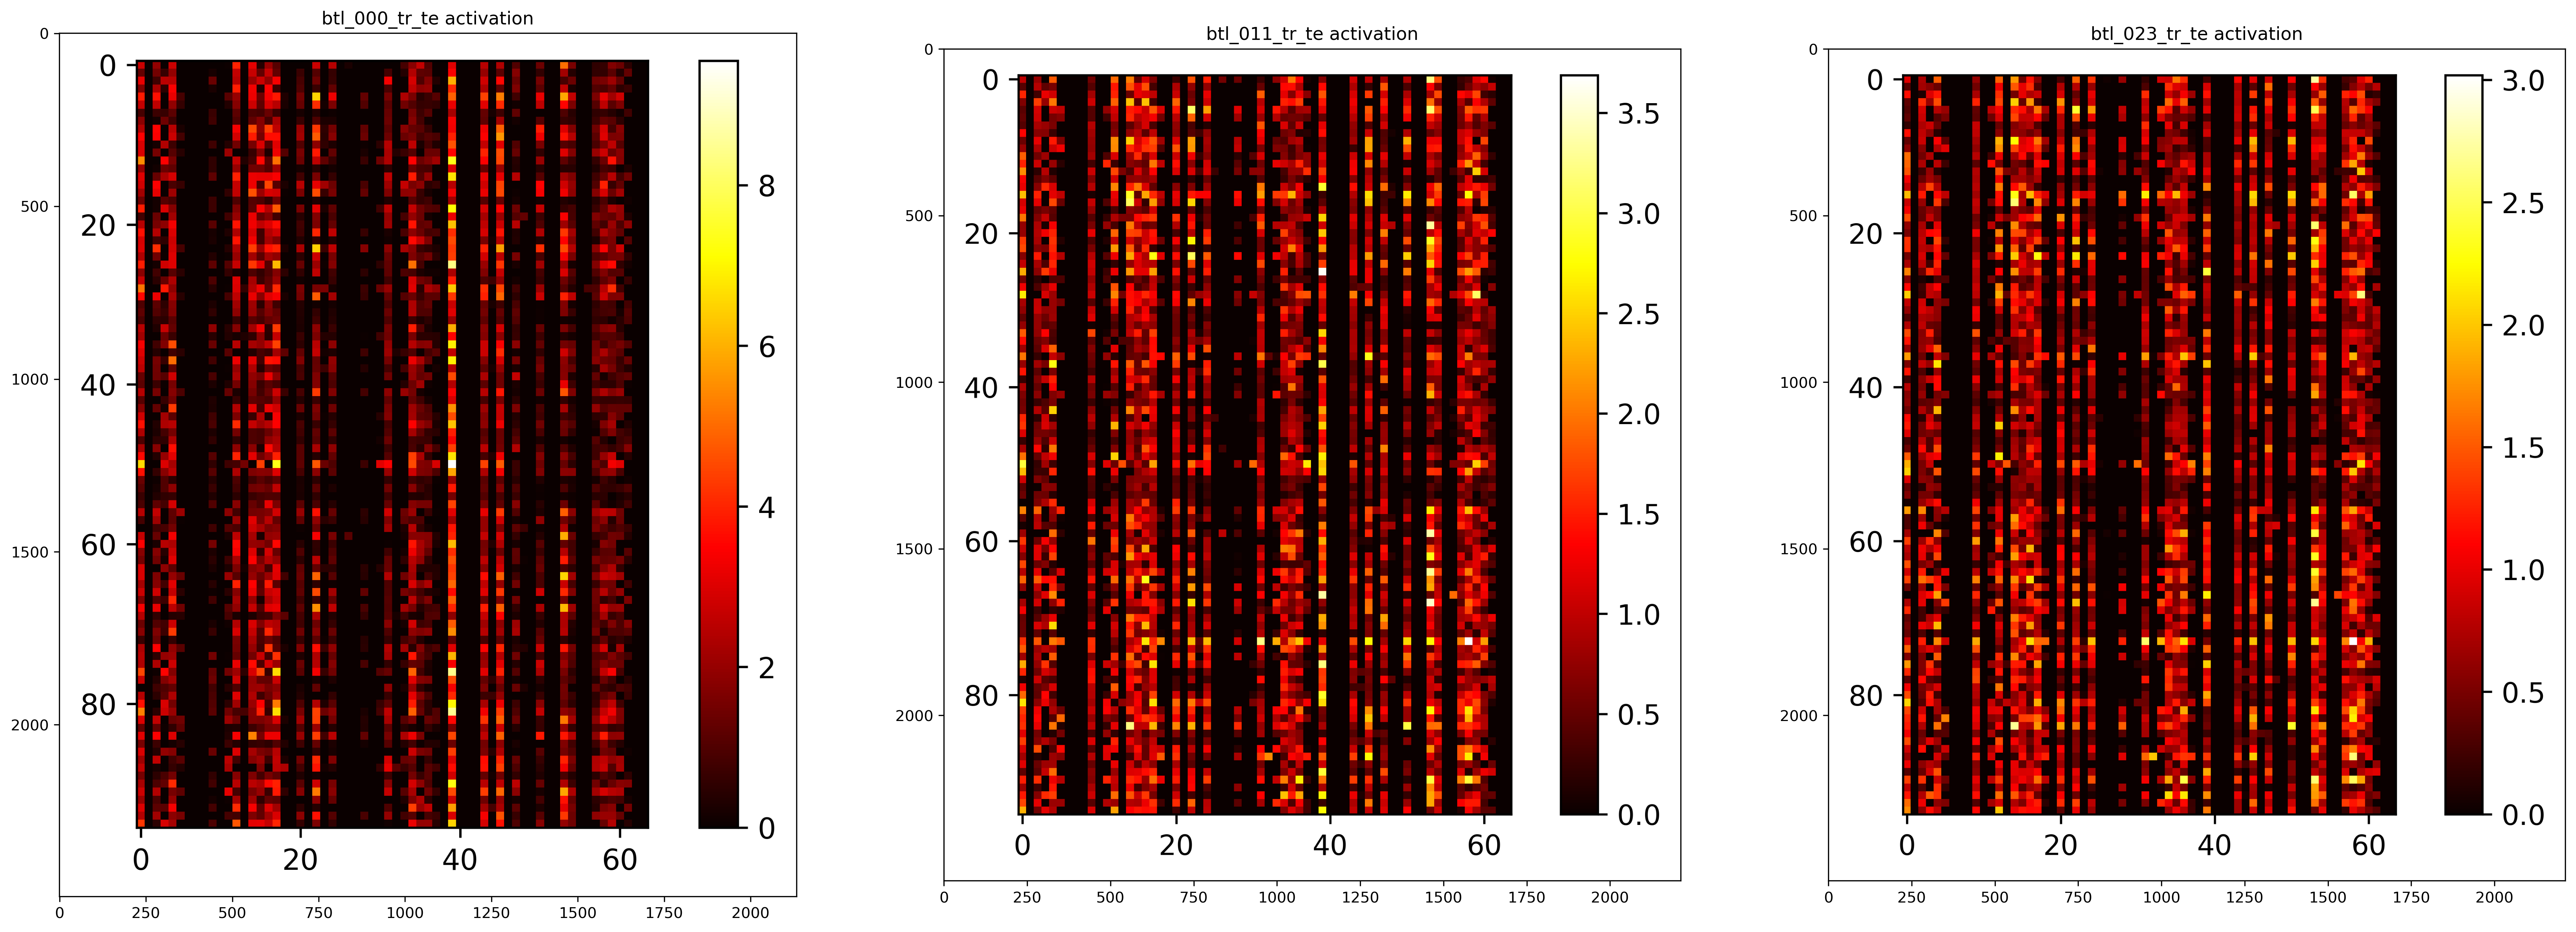

In [61]:
import vae_utils as vu
impL.reload(vu)
vu.plot_cf(cf_int=454, data_log_keys = ['tr_te', 'te'], max_act_ep=None, plot_cnt = 3,
            select_id_type='linspace', k_loss_disp_list={'bottleneck_kmeans'},
            experiments_folder='/home/doga/DataFolder/vaesae_experiments/FM',
            exp_base_name='exp_conv_ae_simple_is28_cf',
            plt_min_max_lines=True)

tr_te  - log is loaded with len:  42
te  - log is loaded with len:  42
skipping -  valid loss
skipping -  reconstruction
bottleneck_kmeans :
tr_te: min(@epoc12:53.7350), max(@epoc3:62.2200), max_list([34 19 38 32  3])
te: min(@epoc31:54.2500), max(@epoc9:63.2900), max_list([17 40 15 13  9])
0*/home/doga/DataFolder/vaesae_experiments_cor/exp_linear_vae_FMNIST_is28_cf530/btl_000_tr_va_.png*
0*/home/doga/DataFolder/vaesae_experiments_cor/exp_linear_vae_FMNIST_is28_cf530/btl_000_tr_te_.png*
[Errno 2] No such file or directory: '/home/doga/DataFolder/vaesae_experiments_cor/exp_linear_vae_FMNIST_is28_cf530/btl_000_tr_te_.png'


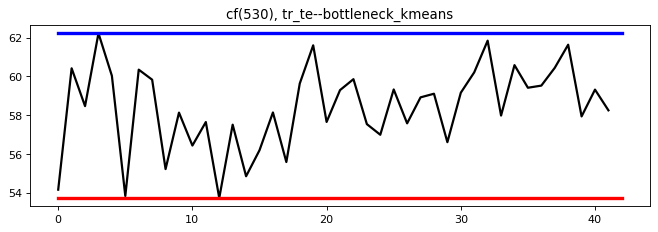

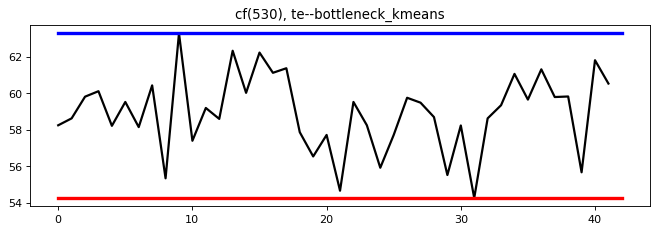

In [62]:
vu.plot_cf(cf_int=530, data_log_keys = ['tr_te', 'te'], max_act_ep=None, plot_cnt = 3,
            select_id_type='linspace', k_loss_disp_list={'bottleneck_kmeans'},
            experiments_folder='/home/doga/DataFolder/vaesae_experiments_cor',
            exp_base_name='exp_linear_vae_FMNIST_is28_cf',
            plt_min_max_lines=True)

In [11]:
silhouette_avg, silhouette_values_hl = funcH.calc_silhouette_params(bottleneck_vec, pred_vec)

Calculating silhouette score for (60000, 32) for n_clusters = 32  -  2021-02-26 22:29:16.262085
For n_clusters = 32 The average silhouette_score is : 0.24382466 . ElapsedTime(33.93)
Computing sample_silhouette_values -  2021-02-26 22:29:50.187510
Computed.. ElapsedTime(34.38)


In [13]:
kluster_centroids = funcH.get_cluster_centroids(ft=bottleneck_vec, predClusters=pred_vec, kluster_centers=None, verbose=0)

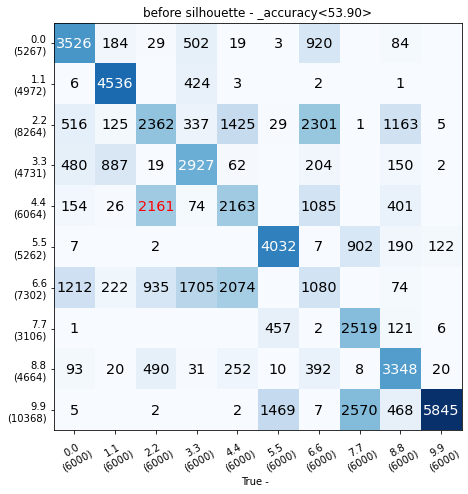

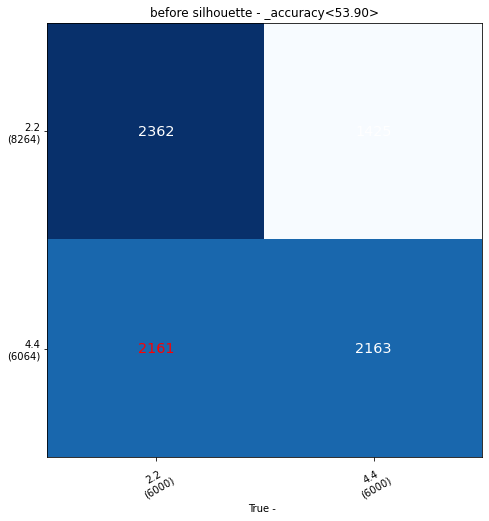

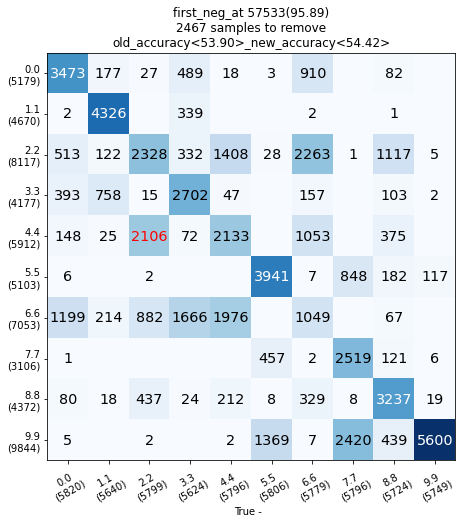

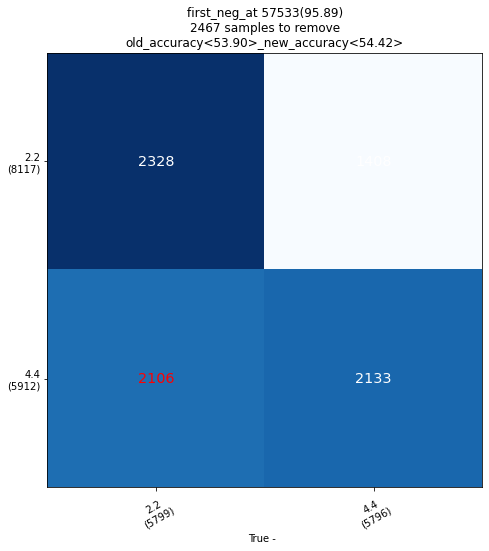

*-*-*
*-*-*


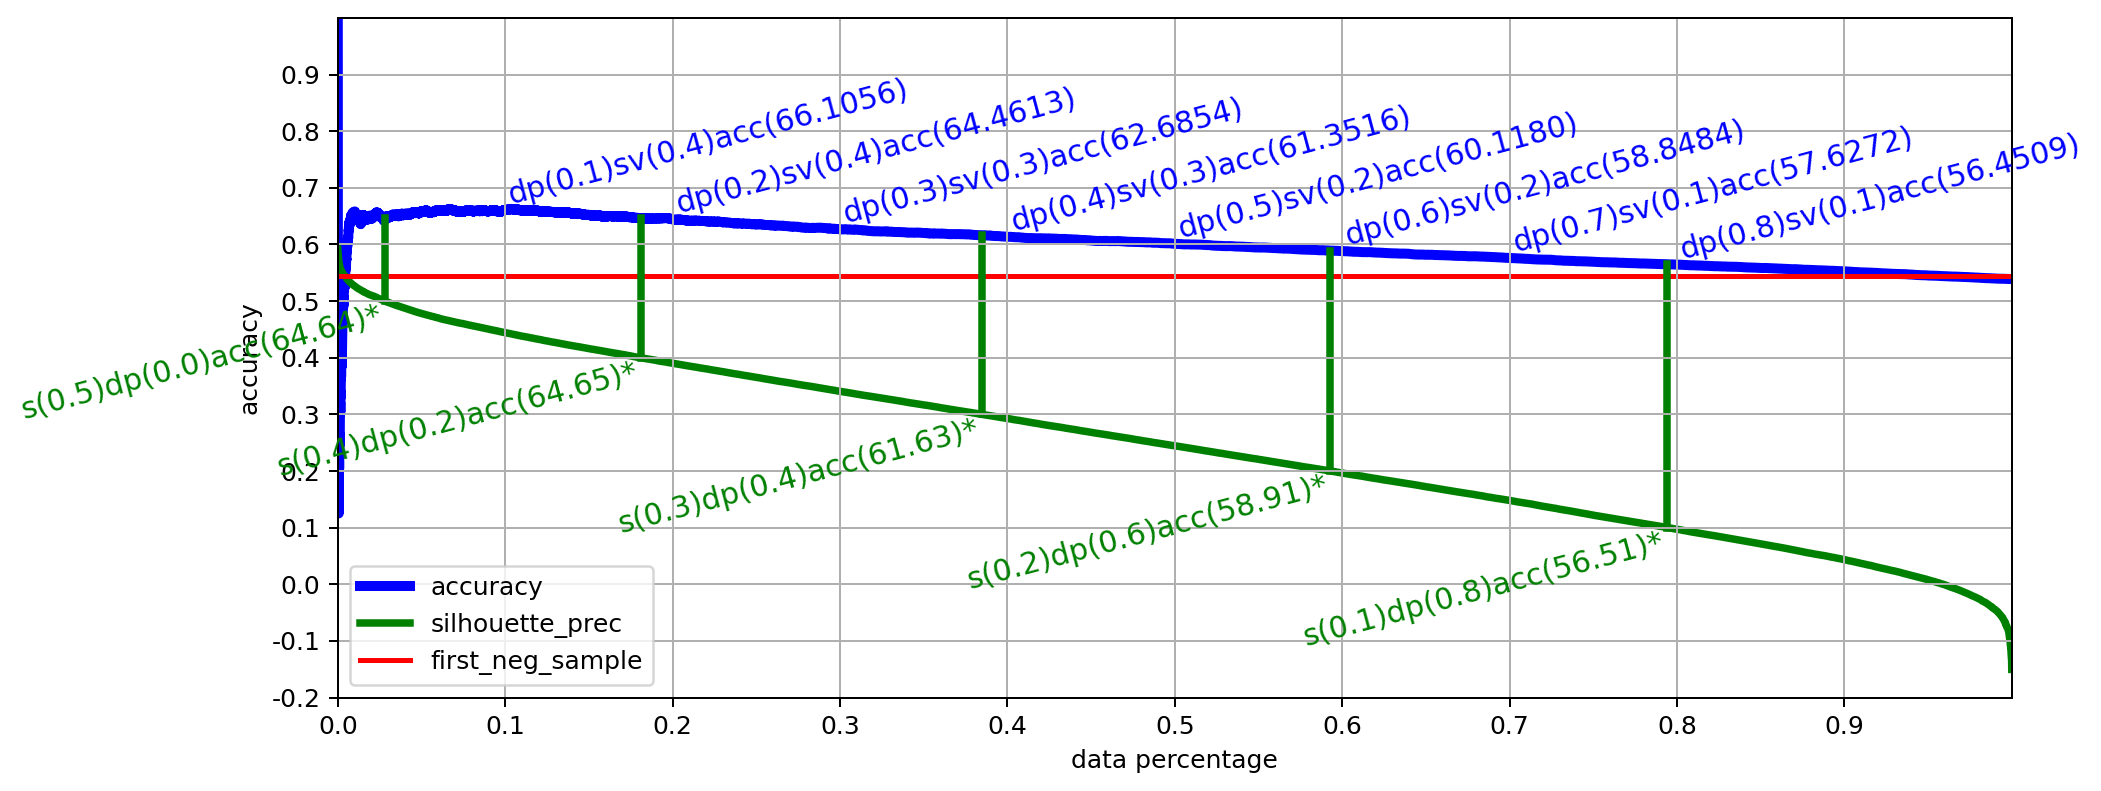

In [14]:
result_dict = funcH.analyze_silhouette_values(silhouette_values_hl, pred_vec, lab_vec,
                                    centroid_info_pdf=kluster_centroids,
                                    label_names=None, conf_plot_save_to='',
                                    figsize=(12, 5), lw=[4, 3, 2], show_title=False, str_deg=15, str_size=12)

1. we have silhouette scores in silhouette_values_hl
2. predictions and their ground truth labels at pred_vec and lab_vec
3. what if for each cluster we only take the knear1 samples,
   sort them by their sum of 2 silhouette values
   and only approve if the couple is above average silhouette score?
4. correspondance_tuple hass the original idx of values
   silhouette_values_hl also is that way

In [28]:
print(correspondance_tuple)
n = len(pred_vec)
print(n)

(array([ 5411, 41018, 18547, ..., 55753, 37298, 54439]), array([ 9305, 54936, 19453, ..., 40222, 36362, 55198]))
60000


In [62]:
tuple_sihouette_score_sum = np.asarray([silhouette_values_hl[correspondance_tuple[0][i]]+silhouette_values_hl[correspondance_tuple[1][i]] for i in range(n)])

In [63]:
tuple_idx = np.argsort(-tuple_sihouette_score_sum)

In [64]:
print(tuple_sihouette_score_sum[tuple_idx[:10]])

[1.1828668 1.1828668 1.177655  1.1718588 1.17165   1.1687257 1.1677461
 1.1677461 1.166327  1.166327 ]


In [72]:
tup_sor_a_idx = correspondance_tuple[0][tuple_idx]
tup_sor_b_idx = correspondance_tuple[1][tuple_idx]
lab_vec_a = lab_vec[tup_sor_a_idx]
lab_vec_b = lab_vec[tup_sor_b_idx]
print(lab_vec_a)
print(lab_vec_b)
_cn_a = []
_cn_b = []
uniq_class_cnt_perc_a = np.zeros(lab_vec_a.shape)
uniq_class_cnt_perc_b = np.zeros(lab_vec_b.shape)
for i in range(n):
    if lab_vec_a[i] not in _cn_a:
        _cn_a.append(lab_vec_a[i])
    if lab_vec_b[i] not in _cn_b:
        _cn_b.append(lab_vec_b[i])
    uniq_class_cnt_perc_a[i] = len(_cn_a)
    uniq_class_cnt_perc_b[i] = len(_cn_b)
print(uniq_class_cnt_perc_a)
print(uniq_class_cnt_perc_b)

[0 6 6 ... 0 1 3]
[6 0 6 ... 3 1 0]
[ 1.  2.  2. ... 10. 10. 10.]
[ 1.  2.  2. ... 10. 10. 10.]


In [66]:
print(np.sum(lab_vec_a==lab_vec_b)/len(lab_vec_a))

0.7293


In [69]:
pred_cumsum = np.cumsum(lab_vec_a == lab_vec_b) / np.cumsum(lab_vec_b==lab_vec_b)
max_run_acc_idx = np.argmax(pred_cumsum)
max_run_acc = pred_cumsum[max_run_acc_idx]
print("max_run_acc({:6.4f}), at {:d}(%{:4.2f})".format(max_run_acc, max_run_acc_idx, max_run_acc_idx/n))
data_perc_vec = np.arange(0, len(pred_cumsum)) / len(pred_cumsum)

max_run_acc(0.8887), at 574(%0.01)


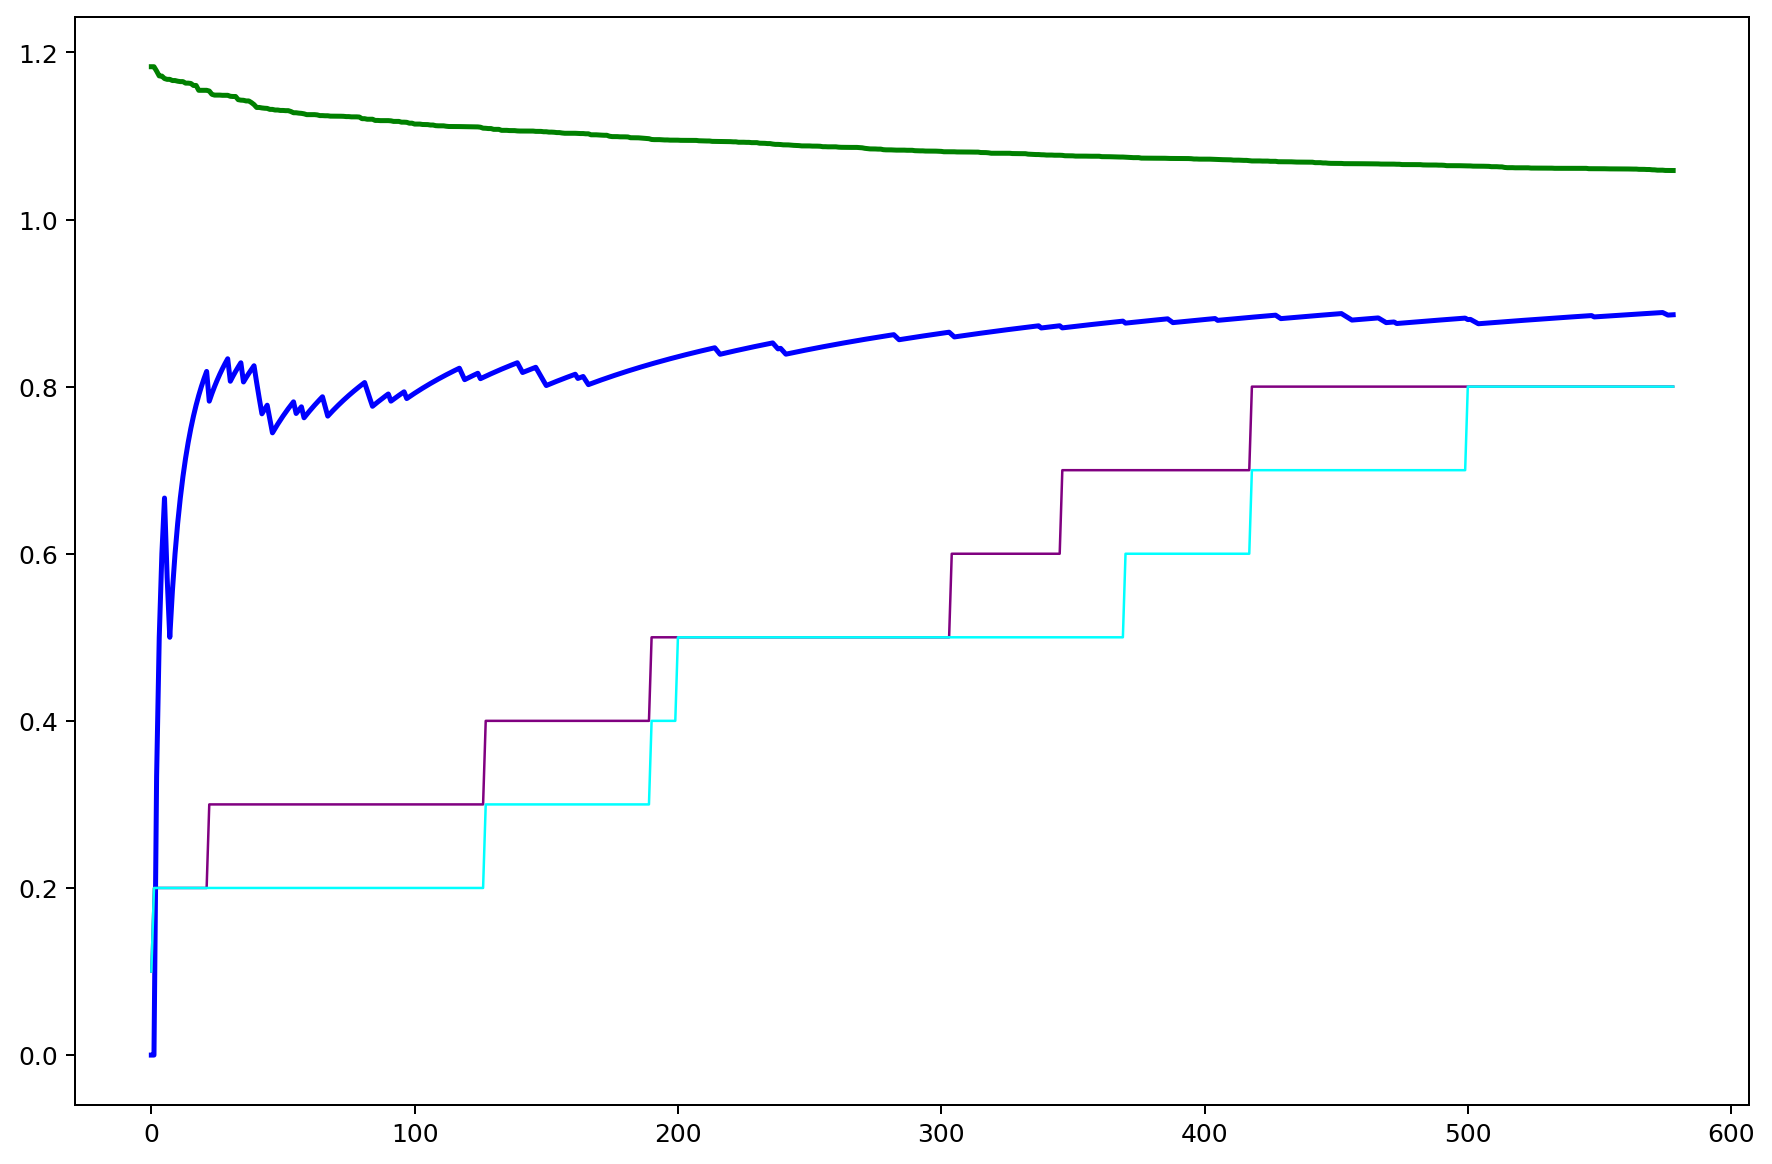

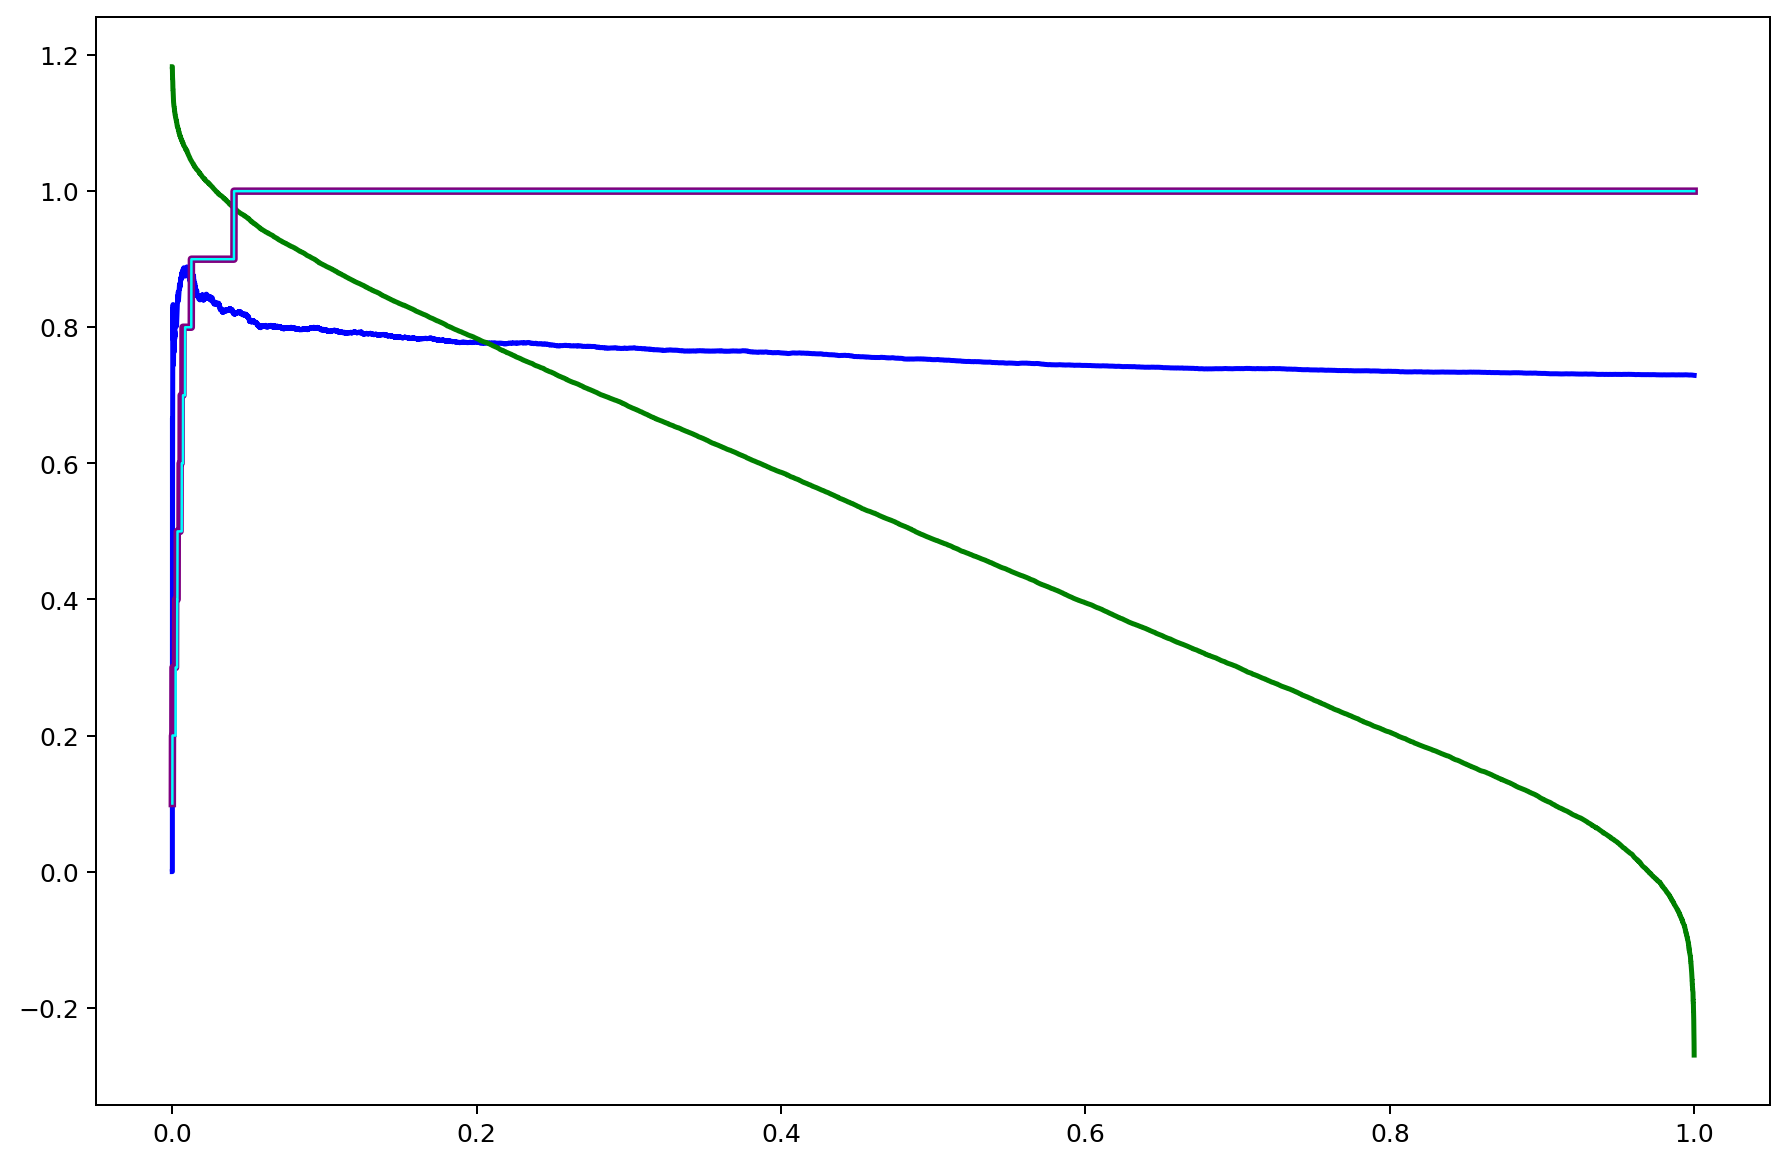

In [76]:
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots(1, figsize=(12,8), dpi=180)
ax.plot(np.arange(max_run_acc_idx+5), pred_cumsum[:max_run_acc_idx+5], lw=2, label='accuracy', color='blue', ls='-', zorder=0)
ax.plot(np.arange(max_run_acc_idx+5), tuple_sihouette_score_sum[tuple_idx[:max_run_acc_idx+5]], lw=2, label='silhouette_prec', color='green', ls='-', zorder=0)
ax.plot(np.arange(max_run_acc_idx+5), uniq_class_cnt_perc_a[:max_run_acc_idx+5]/10.0, lw=1, label='silhouette_prec', color='purple', ls='-', zorder=0)
ax.plot(np.arange(max_run_acc_idx+5), uniq_class_cnt_perc_b[:max_run_acc_idx+5]/10.0, lw=1, label='silhouette_prec', color='cyan', ls='-', zorder=0)
plt.show()

plt.close('all')
fig, ax = plt.subplots(1, figsize=(12,8), dpi=180)
ax.plot(data_perc_vec, pred_cumsum, lw=2, label='accuracy', color='blue', ls='-', zorder=0)
ax.plot(data_perc_vec, tuple_sihouette_score_sum[tuple_idx], lw=2, label='silhouette_prec', color='green', ls='-', zorder=0)
ax.plot(data_perc_vec, uniq_class_cnt_perc_a/10.0, lw=3, label='silhouette_prec', color='purple', ls='-', zorder=0)
ax.plot(data_perc_vec, uniq_class_cnt_perc_b/10.0, lw=1, label='silhouette_prec', color='cyan', ls='-', zorder=0)
plt.show()

In [55]:
pip install mplcursors

     |████████████████████████████████| 86 kB 408 kB/s eta 0:00:01
  Created wheel for mplcursors: filename=mplcursors-0.4-py3-none-any.whl size=19968 sha256=b706accb9ce7127938dc1a94cfdf669edf6b3d2588fe22224566957f898d190a
  Stored in directory: /home/doga/.cache/pip/wheels/09/8a/90/32b30a664f7c3c4b0062f2cc5593696d1d82e758dc54d5cc1f
Successfully built mplcursors
Note: you may need to restart the kernel to use updated packages.


In [38]:
import torch
import numpy as np
b_v = np.random.rand(4,1,10)
print(b_v.shape[0])
print(1 in b_v.shape)
print(b_v.squeeze().shape)
print(1 in b_v.squeeze().shape)
weights = np.random.rand(4,)
print(weights)
print(weights.shape)
torch.from_numpy(np.array([weights,]*10).T).size()

4
True
(4, 10)
False
[0.18992001 0.04686153 0.29462194 0.74520295]
(4,)


torch.Size([4, 10])